# Seq2Seq tut1


https://github.com/ematvey/tensorflow-seq2seq-tutorials/blob/master/1-seq2seq.ipynb

In [42]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Helper functions

In [39]:
def batch(inputs, max_sequence_length=None):
    """
    Args:
        inputs:
            list of sentences (integer lists)
        max_sequence_length:
            integer specifying how large should `max_time` dimension be.
            If None, maximum sequence length would be used
    
    Outputs:
        inputs_time_major:
            input sentences transformed into time-major matrix 
            (shape [max_time, batch_size]) padded with 0s
        sequence_lengths:
            batch-sized list of integers specifying amount of active 
            time steps in each input sequence
    """
    
    sequence_lengths = [len(seq) for seq in inputs]
    batch_size = len(inputs)
    
    if max_sequence_length is None:
        max_sequence_length = max(sequence_lengths)
    
    inputs_batch_major = np.zeros(shape=[batch_size, max_sequence_length], dtype=np.int32) # == PAD
    
    for i, seq in enumerate(inputs):
        for j, element in enumerate(seq):
            inputs_batch_major[i, j] = element

    # [batch_size, max_time] -> [max_time, batch_size]
    inputs_time_major = inputs_batch_major.swapaxes(0, 1)

    return inputs_time_major, sequence_lengths


def random_sequences(length_from, length_to,
                     vocab_lower, vocab_upper,
                     batch_size):
    """ Generates batches of random integer sequences,
        sequence length in [length_from, length_to],
        vocabulary in [vocab_lower, vocab_upper]
    """
    if length_from > length_to:
            raise ValueError('length_from > length_to')

    def random_length():
        if length_from == length_to:
            return length_from
        return np.random.randint(length_from, length_to + 1)
    
    while True:
        yield [
            np.random.randint(low=vocab_lower,
                              high=vocab_upper,
                              size=random_length()).tolist()
            for _ in range(batch_size)
        ]
        
def next_feed():
    next_batch = next(batches)
    encoder_inputs_, _ = batch(next_batch)
    decoder_targets_, _ = batch(
        [(sequence) + [EOS] for sequence in next_batch]
    )
    decoder_inputs_, _ = batch(
        [[EOS] + (sequence) for sequence in next_batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

In [3]:
x = [[5, 7, 8], [6, 3], [3], [1]]
xt, xlen = batch(x)

In [4]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [5]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units

In [6]:
# shape [encoder_max_time, batch_size]
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')

# shape [encoder_max_time, batch_size]
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

# shape [decoder_max_time, batch_size]
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')

### Embeddings

In [7]:
# Initialize random embeddings matrix
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

### Encoder

In [8]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_inputs_embedded,
    dtype=tf.float32, time_major=True,
)

del encoder_outputs

In [9]:
# encoder_final_state.h -- activations of the hidden layer
# encoder_final_state.c -- output

encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 20) dtype=float32>)

### Decoder

In [10]:
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)

decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    decoder_cell, decoder_inputs_embedded,

    initial_state=encoder_final_state,

    dtype=tf.float32, time_major=True, scope="plain_decoder",
)

In [11]:
# Static : vocab_size
# Dynamic : max_time, batch_size

# shape [max_time, batch_size, hidden_units] 
decoder_outputs

# shape [max_time, batch_size, vocab_size]
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)

decoder_prediction = tf.argmax(decoder_logits, 2)

### Optimizer

In [12]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [14]:
sess.run(tf.global_variables_initializer())

### Test everything is wired correctly

In [17]:
batch_ = [[6], [3, 4], [9, 8, 7]]

batch_, batch_length_ = batch(batch_)
print('batch_encoded:\n' + str(batch_))

din_, dlen_ = batch(np.ones(shape=(3, 1), dtype=np.int32),
                            max_sequence_length=4)
print('decoder inputs:\n' + str(din_))

pred_ = sess.run(decoder_prediction,
    feed_dict={
        encoder_inputs: batch_,
        decoder_inputs: din_,
    })
print('decoder predictions:\n' + str(pred_))

batch_encoded:
[[6 3 9]
 [0 4 8]
 [0 0 7]]
decoder inputs:
[[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
decoder predictions:
[[1 7 7]
 [1 7 7]
 [4 9 9]
 [4 4 9]]


### Toy example

In [24]:
batch_size = 100

batches = random_sequences(length_from=3, length_to=8,
                            vocab_lower=2, vocab_upper=10,
                            batch_size=batch_size)

# print('head of the batch:')
# for seq in next(batches)[:10]:
#     print(seq)

In [43]:
loss_track = []
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch_ in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch_ == 0 or batch_ % batches_in_epoch == 0:
            print('batch {}'.format(batch_))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 0.10126741975545883
  sample 1:
    input     > [4 8 6 0 0 0 0 0]
    predicted > [4 8 6 1 0 0 0 0 0]
  sample 2:
    input     > [3 9 9 0 0 0 0 0]
    predicted > [3 9 9 1 0 0 0 0 0]
  sample 3:
    input     > [7 3 3 9 9 0 0 0]
    predicted > [3 3 9 9 9 1 0 0 0]

batch 1000
  minibatch loss: 0.06616536527872086
  sample 1:
    input     > [9 3 6 3 5 5 0 0]
    predicted > [9 3 6 3 5 5 1 0 0]
  sample 2:
    input     > [8 8 3 8 5 2 0 0]
    predicted > [8 8 3 8 5 2 1 0 0]
  sample 3:
    input     > [8 9 5 2 4 6 9 2]
    predicted > [8 9 5 2 4 6 9 2 1]

batch 2000
  minibatch loss: 0.04467751830816269
  sample 1:
    input     > [2 6 8 3 3 6 7 0]
    predicted > [2 6 8 3 3 6 7 1 0]
  sample 2:
    input     > [3 5 5 3 0 0 0 0]
    predicted > [3 5 5 3 1 0 0 0 0]
  sample 3:
    input     > [9 3 7 0 0 0 0 0]
    predicted > [9 3 7 1 0 0 0 0 0]

batch 3000
  minibatch loss: 0.048737652599811554
  sample 1:
    input     > [3 5 5 0 0 0 0 0]
    predicted > [3 

loss 0.1101 after 300100 examples (batch_size=100)


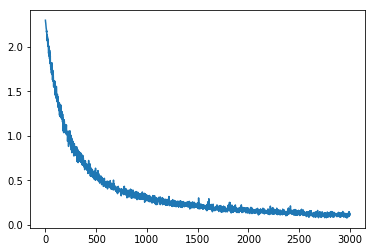

In [41]:
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))